In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
!pip install ultralytics
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
import rembg
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image
from ultralytics import YOLO
from PIL import Image, ImageEnhance


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 53.7GB/s]



0: 384x640 3 persons, 1 handbag, 1 tie, 1 book, 285.7ms
Speed: 11.4ms preprocess, 285.7ms inference, 41.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict
1 label saved to runs/segment/predict/labels


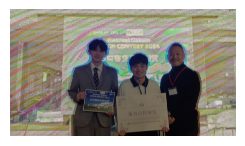

In [ ]:
#カメラの絵
from ultralytics import YOLO

def remove_background(input_image):
    # 背景を削除

    output_image = rembg.remove(input_image,alpha_matting=True,
    alpha_matting_foreground_threshold=100,
    alpha_matting_background_threshold=0,
    alpha_matting_erode_structure_size=20,
    alpha_matting_base_size=1000) #rembgの背景除去で写真の背景を削除

    #cv2.imwrite("rembg_img.png",output_image)
    return output_image
    #except:
    #    return input_image

def apply_mask_to_background(rgba_image, input_image, min_area=1000):
    # RGBA画像を読み込み
    if rgba_image is None:
        print("Error: Cannot open the rgba image.")
        return

    model = YOLO('drive/MyDrive/Loading Leaves/まじっくくれぱす/yolo_model/last.pt')  # 解凍したモデルのパスを指定
    results = model(input_image, save=True, save_txt=True)

    # セグメンテーション結果を確認
    if not results or not results[0].masks:
        print("No masks found in the YOLO segmentation results.")
        return rgba_image  # マスクが見つからなかった場合は元の画像を返す

    # セグメンテーション結果を表示（画像にポリゴンを描画）
    output_img = np.zeros_like(input_image)

    # インスタンスセグメンテーションのマスクを適用
    for i, e in enumerate(results[0].masks.xy):
        # 座標をリシェイプして、1つの物体のマスクを作成
        pos = e.reshape((-1, 1, 2)).astype(np.int32)

        # 面積を計算
        area = cv2.contourArea(pos)
        if area < min_area:
            continue  # 面積が小さい場合は塗りつぶさない
        # 枠内を白で塗りつぶし
        cv2.fillPoly(output_img, [pos], color=(255, 255, 255))  # 白に塗りつぶし

    # output_imgを4チャネル（RGBA）に変更
    # アルファチャンネルを追加（透明度: 255）
    output_img_rgba = cv2.cvtColor(output_img, cv2.COLOR_BGR2BGRA)
    output_img_rgba[:, :, 3] = 255  # アルファチャンネルを255（不透明）に設定

    # アルファチャンネルをマスクとして使用
    alpha_channel = rgba_image[:, :, 3]

    # リサイズ (output_img_rgba をアルファチャンネルのサイズに合わせる)
    output_img_rgba = cv2.resize(output_img_rgba, (alpha_channel.shape[1], alpha_channel.shape[0]))

    # 背景画像を作成（アルファチャンネルを持つ透明な画像）
    background = np.ones_like(rgba_image, dtype=np.uint8) * 255  # 背景を白で作成
    background[:, :, 3] = 0  # アルファチャンネルを0に設定し透明にする

    # マスクを適用
    background_masked = cv2.bitwise_and(background, background, mask=alpha_channel)

    #print("Masked background type:", type(background_masked))
    #print("Masked background shape:", background_masked.shape)

    #print("Output image type:", type(output_img_rgba))
    #print("Output image shape:", output_img_rgba.shape)

    # 出力画像と背景マスクを統合
    background_masked = cv2.bitwise_or(output_img_rgba, background_masked, background_masked)

    # 形態学的変換を使用してマスクのエッジを滑らかに
    kernel = np.ones((3, 3), np.uint8)
    count = 15
    background_masked = cv2.dilate(background_masked, kernel, iterations=count, borderType=cv2.BORDER_REFLECT)
    background_masked = cv2.erode(background_masked, kernel, iterations=count*2, borderType=cv2.BORDER_REFLECT)
    background_masked = cv2.dilate(background_masked, kernel, iterations=count, borderType=cv2.BORDER_REFLECT)

    return background_masked

def apply_mask_to_background2(rgba_image, min_area=1000):
    # RGBA画像を読み込み
    if rgba_image is None:
        print(f"Error: Cannot open {masked_image_path}")
        return

    # アルファチャネルをマスクとして使用
    alpha_channel = rgba_image[:, :, 3]

    # 白い背景画像を作成
    background = np.ones_like(rgba_image, dtype=np.uint8) * 255
    # マスクを適用
    background_masked = cv2.bitwise_and(background, background, mask=alpha_channel)

    #print("Masked background type:", type(background_masked))
    #print("Masked background shape:", background_masked.shape)

    #print("Output image type:", type(output_img_rgba))
    #print("Output image shape:", output_img_rgba.shape)


    # 形態学的変換を使用してマスクのエッジを滑らかに
    kernel = np.ones((3, 3), np.uint8)
    count = 15
    background_masked = cv2.dilate(background_masked, kernel, iterations=count, borderType=cv2.BORDER_REFLECT)
    background_masked = cv2.erode(background_masked, kernel, iterations=count*2, borderType=cv2.BORDER_REFLECT)
    background_masked = cv2.dilate(background_masked, kernel, iterations=count, borderType=cv2.BORDER_REFLECT)

    return background_masked



def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(img):
    max_dim = 512
    # 画像を読み込む
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCVはBGR形式で読み込むためRGBに変換

    img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0  # 0-1の範囲にスケーリング
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # バッチ次元を追加
    return img


def Style_transfer(content_image,style_image):
  hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
  stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
  output_style = tensor_to_image(stylized_image)
  #output_style.save("output_style0.png")
  return output_style

def synthetic(masked_image, input_image, styletransfer_image, type_pattern):
    styletransfer_image = cv2.resize(styletransfer_image, (input_image.shape[1], input_image.shape[0])) #横, 縦
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    #二値化（影を検出しやすくするためにしきい値を設定）
    _, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY_INV)
    # 形態学的処理（膨張などを使って影を強調）
    kernel = np.ones((5,5), np.uint8)
    morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    #エッジ検出（Cannyエッジ検出）
    edges = cv2.Canny(gray_image, 100, 200)  # エッジ検出 (しきい値を調整)
    kernel = np.ones((10, 10), np.uint8)  # 膨張処理用のカーネル
    edges = cv2.dilate(edges, kernel, iterations=1)  # 膨張処理
    #Transfer_imageに影などをのこす
    combined_image = cv2.bitwise_or(morph_image, edges)
    combined_image_back = cv2.bitwise_not(combined_image)

    combined_image = cv2.merge([combined_image, combined_image, combined_image])
    combined_image_back = cv2.merge([combined_image_back, combined_image_back, combined_image_back])
    gray_image = cv2.merge([gray_image, gray_image, gray_image])
    combined_image_back = cv2.bitwise_and(styletransfer_image,combined_image_back)
    combined_image = cv2.bitwise_and(gray_image,combined_image)
    output_result2 = cv2.bitwise_or(combined_image,combined_image_back)
    if masked_image.shape[2] == 4:
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_RGBA2RGB)

    styletransfer_image = cv2.cvtColor(styletransfer_image, cv2.COLOR_RGB2BGR)
    masked_background = cv2.bitwise_not(masked_image)

    #対象物バージョン
    if type_pattern==3 or type_pattern==4:
        dst = cv2.bitwise_and(styletransfer_image, masked_image)
        dst2 = cv2.bitwise_and(input_image, masked_background)
        dst3 = cv2.bitwise_and(output_result2, masked_image)
        result = cv2.bitwise_or(dst, dst2)
        result = cv2.addWeighted(result, 0.70, dst3, 0.30, 1)
    #cv2.imwrite("output_style.png",result)
    #背景バージョン
    else:
        dst = cv2.bitwise_and(input_image, masked_image)
        dst2 = cv2.bitwise_and(styletransfer_image, masked_background)
        dst3 = cv2.bitwise_and(output_result2, masked_background)
        result = cv2.bitwise_or(dst, dst2)
        result = cv2.addWeighted(result, 0.70, dst3, 0.30, 1)
    #cv2.imwrite("output_style2.png",result2)
    return result

def Generate(input_image,style_image, type_pattern):
    # 背景除去処理
    rembg_image = remove_background(input_image)
    if type_pattern==1 or type_pattern==3:
        masked_image = apply_mask_to_background(rembg_image, input_image)
    elif type_pattern==2 or type_pattern==4:
        masked_image = apply_mask_to_background2(rembg_image, input_image)
    #cv2.imwrite("masked_image.png",masked_image)
    content_image = load_img(input_image)
    style_image = Image.fromarray(cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Color(style_image)
    saturation_factor = 3  # 彩度を1.5倍にする
    style_image = enhancer.enhance(saturation_factor)
    style_image = cv2.cvtColor(np.array(style_image), cv2.COLOR_RGB2BGR)
    style_image = load_img(style_image)
    styletransfer_image = Style_transfer(content_image, style_image)
    styletransfer_image = np.array(styletransfer_image)
    result = synthetic(masked_image, input_image, styletransfer_image, type_pattern)

    return result


img_photo = cv2.imread('photo.jpg')
img_drawing = cv2.imread('drawing.jpg')

result = Generate(img_photo,img_drawing,1)
cv2.imwrite("result.png",result)
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
plt.subplot(1, 2, 1)
plt.imshow(result)
plt.axis('off')
plt.show()
